<a href="https://colab.research.google.com/github/johanjun/dacon_molit/blob/main/%EA%B5%90%ED%86%B5%EC%82%AC%EA%B3%A0_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A1%B0%ED%8C%80%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import

In [1]:
#한글폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [256]:
#라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import seaborn as sns
import re
import shutil
import random
import missingno as msno
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import warnings
warnings.filterwarnings(action='ignore')

# Data Load - 서울시 2019-2020 교통사고
- http://taas.koroad.or.kr/gis/mcm/mcl/initMap.do?menuId=GIS_GMP_STS_RSN#

In [3]:
data_dir = '/content/drive/MyDrive/dacon_molit/data/'

In [4]:
df_acci = pd.read_csv(data_dir+'서울시 2019-2020 교통사고.csv')

- 74485 행, 22열로 구성

In [5]:
df_acci.head(3)

,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,법규위반,노면상태,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도
0,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 강서구 방화동,경상사고,0,0,1,0,차대사람 - 횡단중,보행자보호의무위반,포장 - 건조,맑음,교차로 - 교차로횡단보도내,승용,남,26세,상해없음,보행자,남,40세,경상
1,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 구로구 고척동,경상사고,0,0,1,0,차대차 - 추돌,안전운전불이행,포장 - 건조,맑음,단일로 - 기타,이륜,남,23세,상해없음,승용,남,71세,경상
2,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 서초구 서초동,경상사고,0,0,1,0,차대차 - 기타,안전운전불이행,포장 - 건조,맑음,기타 - 기타,승용,남,33세,상해없음,화물,남,51세,경상


In [6]:
df_acci.shape

(74485, 22)

# 분석

## 결측치

- 18열(피해운전자 차종) 부터 21열(피해운전자 상해정도) 까지는 약 2,260개의 null값이 존재

In [7]:
df_acci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74485 entries, 0 to 74484
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   사고번호        74485 non-null  float64
 1   사고일시        74485 non-null  object 
 2   요일          74485 non-null  object 
 3   시군구         74485 non-null  object 
 4   사고내용        74485 non-null  object 
 5   사망자수        74485 non-null  int64  
 6   중상자수        74485 non-null  int64  
 7   경상자수        74485 non-null  int64  
 8   부상신고자수      74485 non-null  int64  
 9   사고유형        74485 non-null  object 
 10  법규위반        74485 non-null  object 
 11  노면상태        74485 non-null  object 
 12  기상상태        74485 non-null  object 
 13  도로형태        74485 non-null  object 
 14  가해운전자 차종    74485 non-null  object 
 15  가해운전자 성별    74485 non-null  object 
 16  가해운전자 연령    74485 non-null  object 
 17  가해운전자 상해정도  74485 non-null  object 
 18  피해운전자 차종    72225 non-null  object 
 19  피해운전자 성별    72225 non-nul

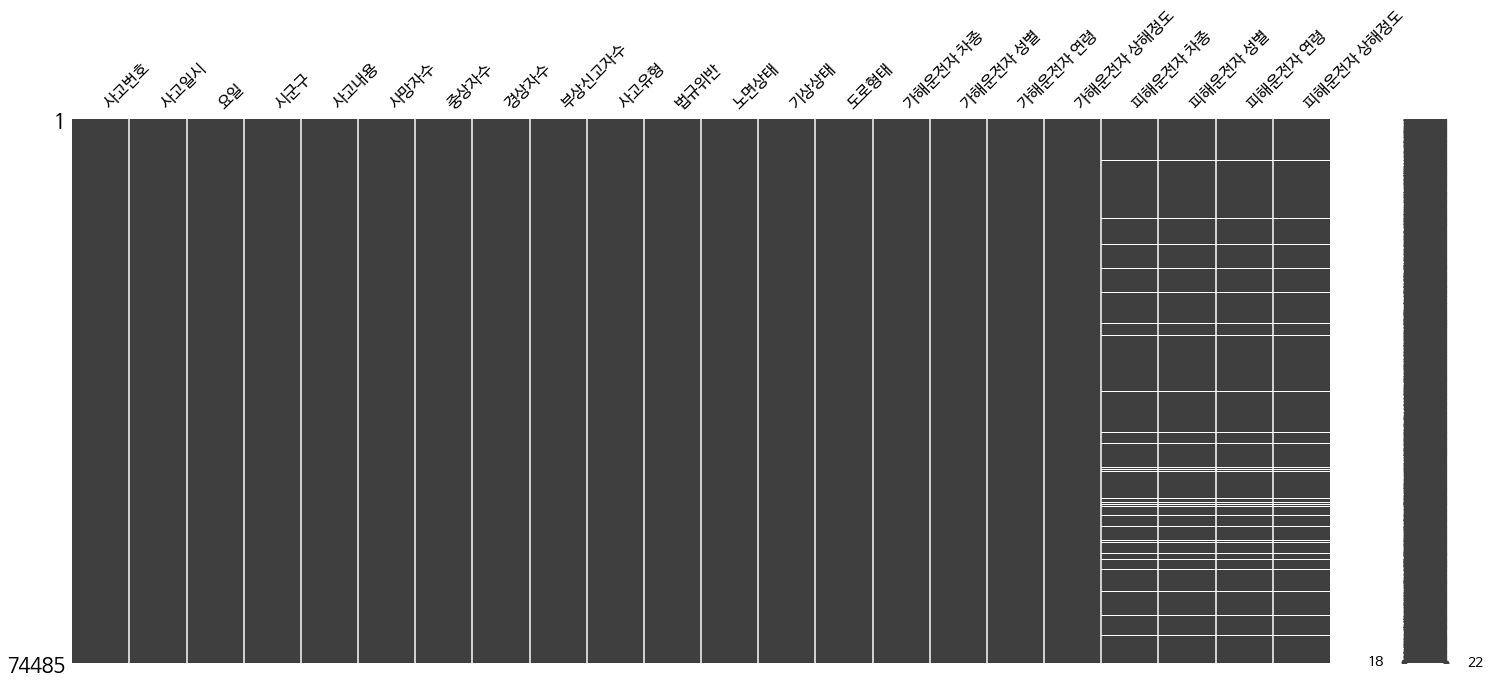

In [8]:
msno.matrix(df_acci)

- 그리고 모두 같은 row에서 null값이 표출됨

In [46]:
a = df_acci[df_acci['피해운전자 차종'].isnull()].index
b = df_acci[df_acci['피해운전자 성별'].isnull()].index
c = df_acci[df_acci['피해운전자 연령'].isnull()].index
d = df_acci[df_acci['피해운전자 상해정도'].isnull()].index

In [50]:
set(a) == set(b) and set(b) == set(c) and set(c) == set(d)

True

In [52]:
df_acci.iloc[74330:74335]

,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,법규위반,노면상태,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도
74330,2.020123e+15,2020년 12월 30일 14시,수요일,서울특별시 영등포구 문래동1가,경상사고,0,0,1,1,차대차 - 측면충돌,안전거리미확보,포장 - 건조,맑음,단일로 - 기타,승용,남,61세,부상신고,승용,남,52세,경상
74331,2.020123e+15,2020년 12월 30일 14시,수요일,서울특별시 강서구 염창동,경상사고,0,0,2,0,차대차 - 추돌,안전거리미확보,포장 - 건조,맑음,단일로 - 기타,화물,남,64세,상해없음,승용,남,41세,경상
74332,2.020123e+15,2020년 12월 30일 14시,수요일,서울특별시 강서구 가양동,경상사고,0,0,1,0,차량단독 - 공작물충돌,안전운전불이행,포장 - 기타,맑음,단일로 - 교량,승용,남,36세,경상,NaN,NaN,NaN,NaN
74333,2.020120e+15,2020년 12월 30일 14시,수요일,서울특별시 양천구 신정동,중상사고,0,1,3,0,차대차 - 추돌,안전운전불이행,포장 - 건조,맑음,단일로 - 기타,승용,남,62세,상해없음,승용,여,59세,경상
74334,2.020123e+15,2020년 12월 30일 15시,수요일,서울특별시 중구 명동2가,사망사고,1,0,0,0,차량단독 - 기타,안전운전불이행,포장 - 건조,맑음,교차로 - 교차로안,승합,남,59세,상해없음,NaN,NaN,NaN,NaN


- 피해자 관련 null인 이유는 차량 단독 사고인 경우로 파악

In [54]:
df_acci[df_acci['피해운전자 차종'].isnull()]['사고유형'].unique()

array(['차량단독 - 기타', '차량단독 - 공작물충돌', '차량단독 - 전도전복 - 전도',
       '차량단독 - 도로외이탈 - 기타', '차량단독 - 전도전복 - 전복', '차량단독 - 주/정차차량 충돌',
       '차량단독 - 도로외이탈 - 추락'], dtype=object)

In [55]:
df_acci['사고유형'].unique()

array(['차대사람 - 횡단중', '차대차 - 추돌', '차대차 - 기타', '차대차 - 측면충돌', '차대사람 - 기타',
       '차대사람 - 차도통행중', '차량단독 - 기타', '차대차 - 후진중충돌', '차대사람 - 길가장자리구역통행중',
       '차대사람 - 보도통행중', '차대차 - 정면충돌', '차량단독 - 공작물충돌', '차량단독 - 전도전복 - 전도',
       '차량단독 - 도로외이탈 - 기타', '차량단독 - 전도전복 - 전복', '차량단독 - 주/정차차량 충돌',
       '차량단독 - 도로외이탈 - 추락'], dtype=object)

## 전처리

### time

In [96]:
df_acci['사고일시'].iloc[0].split(' ')

['2019년', '1월', '1일', '00시']

In [97]:
df_acci['연도'] = [x.split(' ')[0][:4] for x in df_acci['사고일시']]
df_acci['사고 월'] = [x.split(' ')[1] for x in df_acci['사고일시']]
df_acci['사고 일'] = [x.split(' ')[2] for x in df_acci['사고일시']]
df_acci['사고 시각'] = [x.split(' ')[3] for x in df_acci['사고일시']]

In [102]:
df_acci.head(3)

,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,법규위반,노면상태,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,연도,사고 월,사고 일,사고 시각
0,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 강서구 방화동,경상사고,0,0,1,0,차대사람 - 횡단중,보행자보호의무위반,포장 - 건조,맑음,교차로 - 교차로횡단보도내,승용,남,26세,상해없음,보행자,남,40세,경상,2019,1월,1일,00시
1,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 구로구 고척동,경상사고,0,0,1,0,차대차 - 추돌,안전운전불이행,포장 - 건조,맑음,단일로 - 기타,이륜,남,23세,상해없음,승용,남,71세,경상,2019,1월,1일,00시
2,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 서초구 서초동,경상사고,0,0,1,0,차대차 - 기타,안전운전불이행,포장 - 건조,맑음,기타 - 기타,승용,남,33세,상해없음,화물,남,51세,경상,2019,1월,1일,00시


### 발생 장소(동)

In [103]:
df_acci['시군구'].iloc[0].split(' ')

['서울특별시', '강서구', '방화동']

In [107]:
del df_acci['시']
del df_acci['군']
del df_acci['구']

In [108]:
df_acci['시'] = [x.split(' ')[0] for x in df_acci['시군구']]
df_acci['구'] = [x.split(' ')[1] for x in df_acci['시군구']]
df_acci['동'] = [x.split(' ')[2] for x in df_acci['시군구']]

In [109]:
df_acci['구'].unique()

array(['강서구', '구로구', '서초구', '중구', '성동구', '송파구', '노원구', '강남구', '양천구',
       '영등포구', '중랑구', '관악구', '성북구', '강동구', '서대문구', '종로구', '동대문구', '마포구',
       '용산구', '광진구', '동작구', '은평구', '금천구', '강북구', '도봉구', '미분류'],
      dtype=object)

In [114]:
df_acci.head(2)

,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,법규위반,노면상태,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,연도,사고 월,사고 일,사고 시각,시,구,동
0,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 강서구 방화동,경상사고,0,0,1,0,차대사람 - 횡단중,보행자보호의무위반,포장 - 건조,맑음,교차로 - 교차로횡단보도내,승용,남,26세,상해없음,보행자,남,40세,경상,2019,1월,1일,00시,서울특별시,강서구,방화동
1,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 구로구 고척동,경상사고,0,0,1,0,차대차 - 추돌,안전운전불이행,포장 - 건조,맑음,단일로 - 기타,이륜,남,23세,상해없음,승용,남,71세,경상,2019,1월,1일,00시,서울특별시,구로구,고척동


### 전체 건수

In [153]:
df_acci['전체 신고 수'] = df_acci['사망자수'] + df_acci['중상자수'] + df_acci['경상자수'] + df_acci['부상신고자수']

### 연령대

In [264]:
math.trunc?

In [271]:
df_acci['가해운전자 연령대'] = [str(int(x.split('세')[0][0]))+'0대' if x != '미분류' else x for x in df_acci['가해운전자 연령']]

In [295]:
df_acci['피해운전자 연령'] = df_acci['피해운전자 연령'].replace('미분류', np.nan)

In [296]:
df_acci['피해운전자 연령대'] = [str(int(x.split()[0][0]))+'0대' if type(x) != float else x for x in df_acci['피해운전자 연령']]

## 연도별 사고 추이

- 사고유형별 전체 사고건수 연도 비교

In [218]:
df_acci_type = pd.DataFrame(df_acci.groupby(['연도', '사고유형'])['사고유형'].count())

In [219]:
df_acci_type['연도'] = df_acci_type.index.get_level_values(0)
df_acci_type['type'] = df_acci_type.index.get_level_values(1)

- 2019년도에 비해서 2020년에 증가한 유일한 사고유형은 '차대차 - 기타'

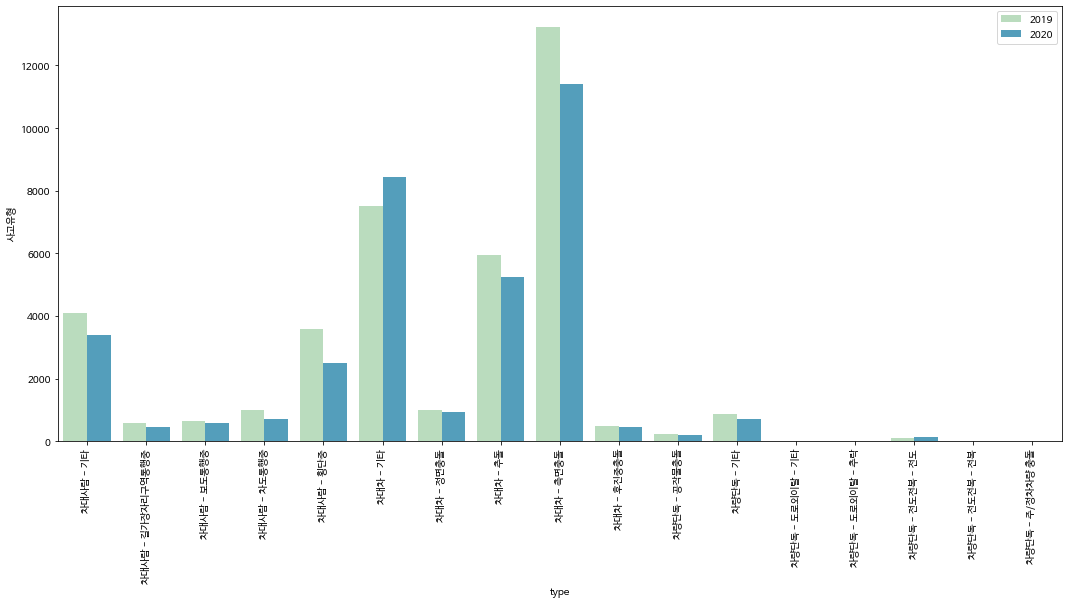

In [222]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_type,
            x='type',
            y='사고유형',
            hue='연도', palette="GnBu")
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

In [299]:
df_acci_vehi_etc = df_acci[df_acci['사고유형']=='차대차 - 기타']

In [300]:
df_acci_vehi_etc.groupby(['연도'])['요일'].value_counts()

연도    요일 
2019  금요일    1179
      화요일    1144
      토요일    1141
      수요일    1088
      목요일    1087
      월요일    1065
      일요일     796
2020  금요일    1406
      수요일    1297
      목요일    1233
      화요일    1232
      토요일    1199
      월요일    1185
      일요일     888
Name: 요일, dtype: int64

In [326]:
for i in df_acci_vehi_etc.iloc[:, [2]]:
  # print(i)
  # for j in df_acci_vehi_etc.groupby(['연도'])[i].value_counts():
    # print(j)
    for k in range(len(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2019'])):
      val = round((int(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2020'][k])
                    - int(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2019'][k])) \
                    / int(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2019'][k])*100, 2)
      # if val >= 5 :
      print(i, df_acci_vehi_etc.groupby(['연도'])['요일'].value_counts().index[k][1], val, '%')

요일 금요일 19.25 %
요일 화요일 13.37 %
요일 토요일 8.06 %
요일 수요일 13.24 %
요일 목요일 10.3 %
요일 월요일 11.27 %
요일 일요일 11.56 %


In [301]:
len(df_acci_vehi_etc.groupby(['연도'])['요일'].value_counts().loc['2019'])

7

In [302]:
print(round((int(df_acci_vehi_etc.groupby(['연도'])['요일'].value_counts().loc['2020'][0]) - int(df_acci_vehi_etc.groupby(['연도'])['요일'].value_counts().loc['2019'][0])) / int(df_acci_vehi_etc.groupby(['연도'])['요일'].value_counts().loc['2019'][0])*100, 2), "%")

19.25 %


In [329]:
for i in df_acci_vehi_etc.iloc[:, [2, 4, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 25, 27, 28, 30, 31]]:
  for j in range(len(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2019'])):
    val = round((int(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2020'][j])
                  - int(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2019'][j])) \
                  / int(df_acci_vehi_etc.groupby(['연도'])[i].value_counts().loc['2019'][j])*100, 2)
    if val >= 50 :
      print(i, df_acci_vehi_etc.groupby(['연도'])[i].value_counts().index[j][1], val, '%')

사고내용 사망사고 50.0 %
법규위반 과속 91.67 %
법규위반 보행자보호의무위반 400.0 %
노면상태 포장 - 기타 89.22 %
노면상태 포장 - 서리/결빙 133.33 %
기상상태 눈 100.0 %
가해운전자 차종 건설기계 61.11 %
가해운전자 차종 개인형이동수단(PM) 141.18 %
가해운전자 차종 사륜오토바이(ATV) 200.0 %
피해운전자 차종 기타불명 94.74 %
피해운전자 상해정도 사망 150.0 %
동 광희동2가 50.0 %
동 구기동 50.0 %
동 남창동 50.0 %
동 능동 50.0 %
동 동소문동6가 50.0 %
동 동숭동 50.0 %
동 만리동2가 50.0 %
동 문래동1가 50.0 %
동 문배동 50.0 %
동 보문동2가 50.0 %
동 봉래동1가 50.0 %
동 구수동 100.0 %
동 금호동2가 100.0 %
동 남대문로3가 100.0 %
동 남산동2가 100.0 %
동 남학동 100.0 %
동 내자동 100.0 %
동 누상동 100.0 %
동 당인동 100.0 %
동 당주동 100.0 %
동 동빙고동 100.0 %
동 동선동2가 100.0 %
동 동선동5가 100.0 %
동 동소문동1가 100.0 %
동 동소문동3가 100.0 %
동 동소문동5가 100.0 %
동 동소문동7가 100.0 %
동 동자동 100.0 %
동 명동1가 100.0 %
동 명륜4가 100.0 %
피해운전자 연령대 90대 60.0 %


- 구별 전체 사고건수 연도 비교

In [204]:
df_acci_total = pd.DataFrame(df_acci.groupby(['연도', '구'])['사고유형'].count())

In [206]:
df_acci_total['연도'] = df_acci_total.index.get_level_values(0)
df_acci_total['구'] = df_acci_total.index.get_level_values(1)

- 전체 사고 건수가 증가한 구 : 강남구, 관악구, 성동구

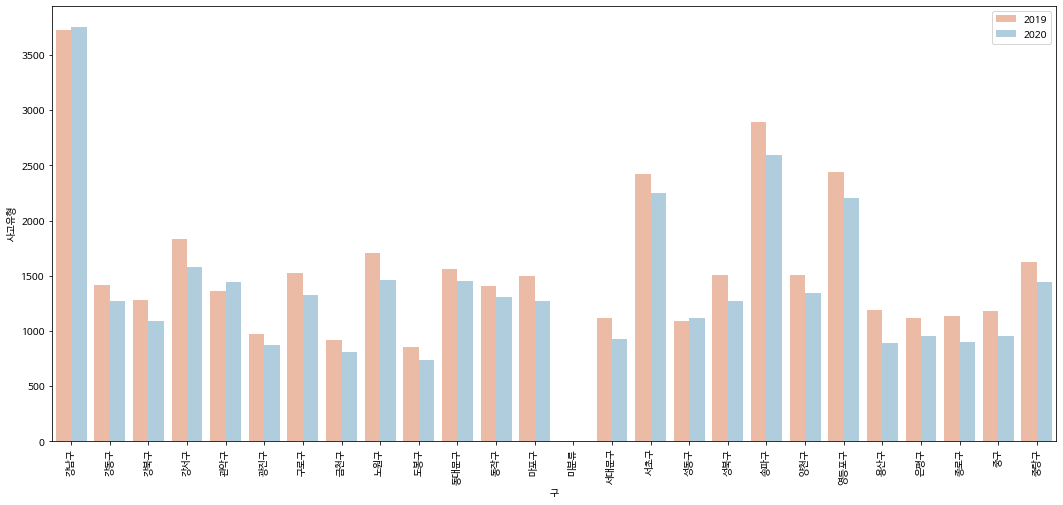

In [210]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_total,
            x='구',
            y='사고유형',
            hue='연도', palette="RdBu")
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

- 전체 부상신고건수 연도 비교

In [178]:
df_acci_year = pd.DataFrame(df_acci.groupby(['연도', '구']).sum())

In [187]:
df_acci_year['연도'] = df_acci_year.index.get_level_values(0)

In [183]:
df_acci_year['구'] = df_acci_year.index.get_level_values(1)

- 부상자 신고 건수가 증가한 구 : 강남구, 관악구, 성동구

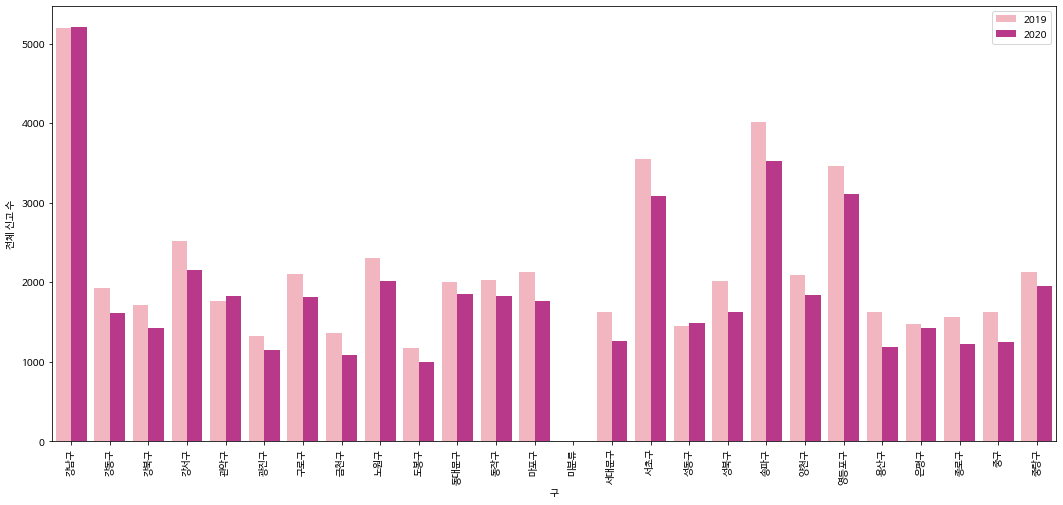

In [192]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_year,
            x='구',
            y='전체 신고 수',
            hue='연도', palette="RdPu")
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

## 가장 많은 사고 유형

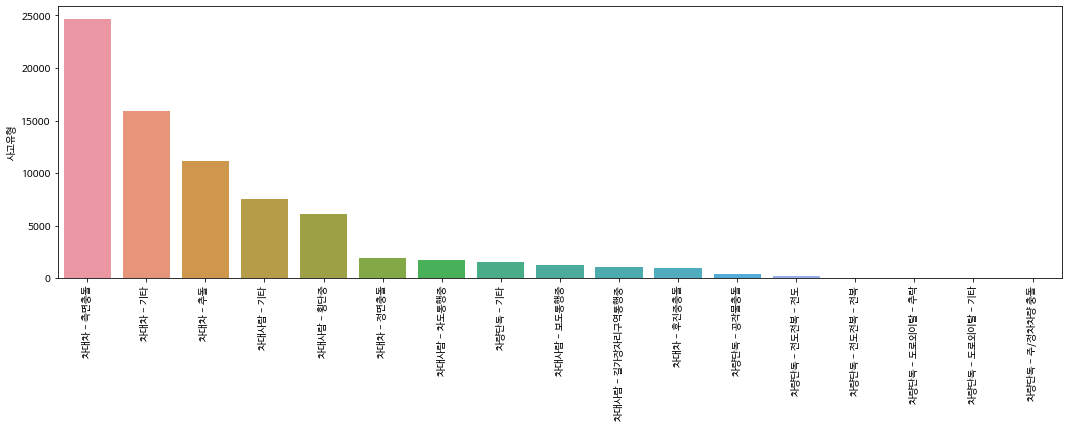

In [112]:
plt.figure(figsize=(18, 5))
sns.barplot(x=df_acci['사고유형'].value_counts().index, y=df_acci['사고유형'].value_counts(), data=df_acci)
plt.xticks(rotation=90)
plt.show()